In [76]:
ls data4stack/

lgb_stack/       mubi_20171125_2/ mubi_20171125_4/ tian_20171126/
mubi_20171125/   mubi_20171125_3/ mubi_20171125_5/ tian_20171126_1/


In [33]:
import os
import pandas as pd
import matplotlib.pylab as plt
from sklearn.model_selection import StratifiedKFold, train_test_split

In [77]:
train = pd.read_csv('data/train.csv',usecols=['target'])
test = pd.DataFrame()

In [78]:
foldernames = os.popen('ls data4stack').readlines()

In [79]:
foldernames

['lgb_stack\n',
 'mubi_20171125\n',
 'mubi_20171125_2\n',
 'mubi_20171125_3\n',
 'mubi_20171125_4\n',
 'mubi_20171125_5\n',
 'tian_20171126\n',
 'tian_20171126_1\n']

In [80]:
for foldername in foldernames:
    foldername = foldername[:-1]
    train[foldername] = pd.read_csv('data4stack/{0}/train4stack.csv'.format(foldername))
    test[foldername] = pd.read_csv('data4stack/{0}/test4stack.csv'.format(foldername))


In [81]:
train.head()

,target,lgb_stack,mubi_20171125,mubi_20171125_2,mubi_20171125_3,mubi_20171125_4,mubi_20171125_5,tian_20171126,tian_20171126_1
0,0,0.040483,0.051245,0.048280,0.048640,0.049065,0.577594,0.069212,0.040211
1,0,0.031868,0.030891,0.033551,0.031431,0.033893,0.464457,0.047779,0.022514
2,0,0.026850,0.020946,0.020689,0.022028,0.023877,0.306400,0.030663,0.021269
3,0,0.024135,0.015791,0.016253,0.014553,0.014347,0.285240,0.022902,0.015595
4,0,0.031031,0.027638,0.041812,0.036286,0.036420,0.467099,0.054779,0.039256


In [82]:
test.head()

,lgb_stack,mubi_20171125,mubi_20171125_2,mubi_20171125_3,mubi_20171125_4,mubi_20171125_5,tian_20171126,tian_20171126_1
0,0.029462,0.025915,0.027955,0.027292,0.030848,0.397098,0.039368,0.023685
1,0.028333,0.023498,0.025048,0.025674,0.027742,0.391438,0.039615,0.024046
2,0.027723,0.025396,0.023973,0.026053,0.025537,0.378132,0.037616,0.017658
3,0.023434,0.014122,0.013695,0.013879,0.013469,0.256923,0.022206,0.014766
4,0.033673,0.033667,0.035829,0.035695,0.035463,0.483296,0.054306,0.034534


In [14]:
def ginic(actual, pred):
    actual = np.asarray(actual) 
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalized(a, p):
    if p.ndim == 2:
        p = p[:,1] 
    return ginic(a, p) / ginic(a, a)
    
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score


def gini_lgb(pred, dtrain):
    y = list(dtrain.get_label())
    score = ginic(y, pred) / ginic(y, y)
    return [('gini', score, True)]


In [40]:
from sklearn.model_selection import KFold

class CustomGridCV(object):
    def __init__(self, X, y, model, metric, griddata, cv=5):
        self.X = X
        self.y = y
        self.model = model
        self.metric = metric
        self.params = self.gridpoints(griddata)
        self.cv = cv
        self.bestScore = None
        self.bestParams = None
        
    def gridpoints(self, data):
        newparams = [{}]
        for k in data.keys():
            params = newparams
            newparams = []
            for v in data[k]:
                for param in params:
                    item = param.copy()
                    item[k]=v
                    newparams.append(item)           
        return newparams
    
    def GridSearch(self):
        for param in self.params:
            self.model.set_params(**param)
            score = self.KFoldScore()
            if self.bestScore==None or self.bestScore<score:
                self.bestScore = score
                self.bestParams = param
            print("Score: {0:.5f}, Params: {1}".format(score,param))
    
    def KFoldScore(self):
        kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
        y_pred = np.zeros(len(self.y))

        for train_index, test_index in kf.split(self.X,self.y):
            train_X, test_X = self.X[train_index], self.X[test_index]
            train_y, test_y = self.y[train_index], self.y[test_index]
            self.model.fit(train_X,train_y)
            #y_pred[test_index] = self.model.predict_proba(test_X)[:,1]
            y_pred[test_index] = self.model.predict(test_X)
            #print y_pred[test_index]

        return self.metric(self.y,y_pred)
    
    def Best(self):
        return self.bestScore, self.bestParams

In [11]:

import pandas as pd
import numpy as np

def PrepareData(df):
    #df = pd.read_csv(trainpath,nrows=nrows)

    features = list(df.columns)
    target = 'target'
    features.remove(target)

    X = np.array(df[features])
    y = np.array(df[target])
    return X, y

In [12]:

from sklearn.linear_model import Lasso, LinearRegression, Ridge

In [41]:
X, y = PrepareData(train)
model = Lasso(positive=True,fit_intercept=False)
griddata = {'alpha':[1e-4,1e-5,1e-6,1e-7,1e-8]}
GCV = CustomGridCV(X, y, model, gini_normalized, griddata)
GCV.GridSearch()

Score: 0.29631, Params: {'alpha': 0.0001}
Score: 0.29197, Params: {'alpha': 1e-05}
Score: 0.29128, Params: {'alpha': 1e-06}
Score: 0.29121, Params: {'alpha': 1e-07}


/Users/sue/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Score: 0.29121, Params: {'alpha': 1e-08}


In [42]:
model = Lasso(positive=True,fit_intercept=False)
griddata = {'alpha':[0.001,0.005,0.008]}
GCV = CustomGridCV(X, y, model, gini_normalized, griddata)
GCV.GridSearch()

Score: 0.30082, Params: {'alpha': 0.001}
Score: 0.30082, Params: {'alpha': 0.005}
Score: 0.30082, Params: {'alpha': 0.008}


In [87]:
LinearRegression?

In [89]:
model = LinearRegression(fit_intercept=False)
#griddata = {'alpha':[0.001,0.005,0.008]}
# GCV = CustomGridCV(X, y, model, gini_normalized, griddata)
# GCV.GridSearch()

In [90]:
model.fit(X,y)

print(model.coef_)

print(gini_normalized(y,model.predict(X)))

[ 0.09015871  0.15098122  0.29302108 -0.23690296  0.18304832  0.01120628
  0.23688016  0.03202152]
0.291909480408


In [62]:
model = Lasso(positive=True,fit_intercept=False,alpha=0.001)

model.fit(X,y)

print(model.coef_)

print(gini_normalized(y,model.predict(X)))

[ 0.          0.          0.          0.          0.          0.07842167
  0.          0.        ]
0.300824656429


In [91]:
sorted(zip(list(test.columns),model.coef_),key=lambda x: x[-1])

[('lgb2', -0.23690295693949742),
 ('GP', 0.011206282596007765),
 ('rbf', 0.032021515774305273),
 ('lgb_stack', 0.090158705274364995),
 ('xgb_mubi', 0.15098122070507955),
 ('lgb3', 0.18304831672617847),
 ('xgb_tian', 0.23688015729343129),
 ('lgb', 0.29302107565069058)]

In [16]:
test.head()

,mubi_20171125,mubi_20171125_2,mubi_20171125_3,mubi_20171125_4,mubi_20171125_5
0,0.025915,0.027955,0.027292,0.030848,0.397098
1,0.023498,0.025048,0.025674,0.027742,0.391438
2,0.025396,0.023973,0.026053,0.025537,0.378132
3,0.014122,0.013695,0.013879,0.013469,0.256923
4,0.033667,0.035829,0.035695,0.035463,0.483296


In [17]:
sub = pd.read_csv('data/test.csv',usecols=['id'])
sub['target'] = model.predict(np.array(test))

In [18]:
sub.head()

,id,target
0,0,0.032007
1,1,0.031350
2,2,0.030548
3,3,0.020450
4,4,0.039162


In [19]:
sub.to_csv('xgb_lgb_gp_stack.csv',index = False)

In [59]:
#example
eg=pd.DataFrame()
a=np.array([1,0,0])
b=np.array([2,0,0])

TypeError: only integer scalar arrays can be converted to a scalar index

In [83]:
new_cols = ['lgb_stack','xgb_mubi','lgb','lgb2','lgb3','GP','xgb_tian','rbf']
test.columns = new_cols
test.columns.values

array(['lgb_stack', 'xgb_mubi', 'lgb', 'lgb2', 'lgb3', 'GP', 'xgb_tian',
       'rbf'], dtype=object)

In [84]:
train.columns.values

array(['target', 'lgb_stack', 'mubi_20171125', 'mubi_20171125_2',
       'mubi_20171125_3', 'mubi_20171125_4', 'mubi_20171125_5',
       'tian_20171126', 'tian_20171126_1'], dtype=object)

In [68]:
y=train['target'].values
train.drop(['target'],axis=1,inplace=True)
train.columns.values

array(['lgb_stack', 'mubi_20171125', 'mubi_20171125_2', 'mubi_20171125_3',
       'mubi_20171125_4', 'mubi_20171125_5', 'tian_20171126',
       'tian_20171126_1'], dtype=object)

In [85]:
train.columns =  ['target','lgb_stack','xgb_mubi','lgb','lgb2','lgb3','GP','xgb_tian','rbf']
test.columns = new_cols
train.columns.values

array(['target', 'lgb_stack', 'xgb_mubi', 'lgb', 'lgb2', 'lgb3', 'GP',
       'xgb_tian', 'rbf'], dtype=object)

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

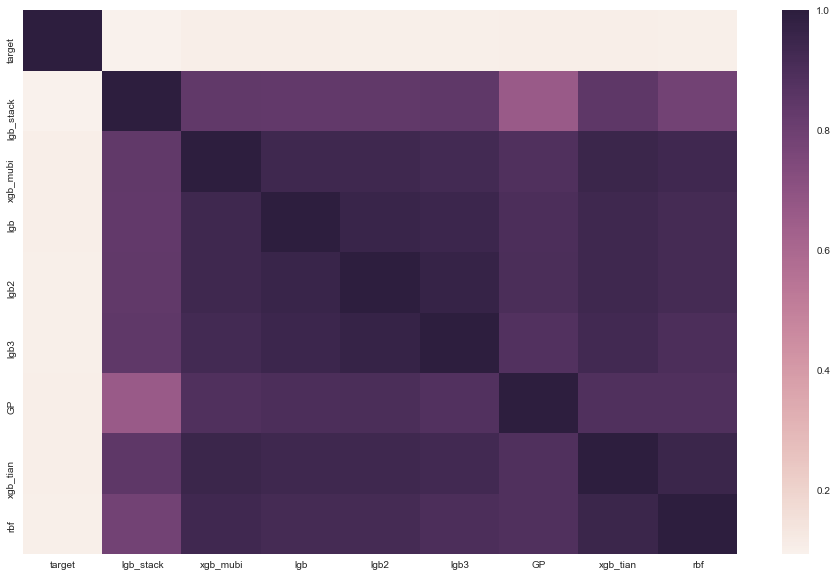

In [86]:
cor = train.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor)

In [ ]:
# All these datasets are from different kaggle kernels
stacked_1 = pd.read_csv('../input/input-datasets/stacked_1.csv')
xgb_submit = pd.read_csv('../input/input-datasets/xgb_submit_1.csv')
Froza_and_Pascal = pd.read_csv('../input/input-datasets/Froza_and_Pascal.csv')
rgf_submit = pd.read_csv('../input/input-datasets/rgf_submit.csv')
gpari = pd.read_csv('../input/input-datasets/gpari.csv')

# Ensemble and create submission 

sub = pd.DataFrame()
sub['id'] = stacked_1['id']
sub['target'] = np.exp(np.mean(
	[	
    sub_1['target'].apply(lambda x: np.log(x)),
    Froza_and_Pascal['target'].apply(lambda x: np.log(x)),
    rgf_submit['target'].apply(lambda x: np.log(x)),
    gpari['target'].apply(lambda x: np.log(x)),
	stacked_1['target'].apply(lambda x: np.log(x)),
	xgb_submit['target'].apply(lambda x: np.log(x))
	], axis =0))

sub.to_csv('sub.csv.gz', index = False, compression = 'gzip')